In [1]:
'''
File name: Project.ipynb
Author: Paul de Fontenay, Arnault Monoyer, Jules Orsat and Matthieu Sayar
Date created: 01/11/2022
Date last modified: 06/11/2022
Last modification by: Matthieu Sayar
Python Version: 3.9.13
'''

'\nFile name: Project.ipynb\nAuthor: Paul de Fontenay, Arnault Monoyer, Jules Orsat and Matthieu Sayar\nDate created: 01/11/2022\nDate last modified: 03/11/2022\nLast modification by: Matthieu Sayar\nPython Version: 3.9.13\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations  #used to create unique pairs from a list
import numpy as np

DATA_FOLDER = 'MovieSummaries/'

In [3]:
moviedata = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', sep = '\t', index_col='wiki_id' , header=None, names=('wiki_id','freebase_id','movie_name','release','revenue','runtime','languages','countries','genres'))
charadata = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', sep = '\t', header=None, names=('wiki_id','freebase_id','release','character_name','actor_dob','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','freebase_chara_map','1','2'))
plots =  pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_id','plot'))

In [4]:
charadata.set_index('wiki_id',inplace=True)
plots.set_index('wiki_id',inplace=True)

### Movie data analysis

In [5]:
indexes = moviedata.index.intersection(charadata.index)
indexes = plots.index.intersection(indexes)

moviedata_filtered = moviedata.loc[indexes]
charadata_filtered = charadata.loc[indexes]
plots_filtered = plots.loc[indexes]

In [6]:
print(len(moviedata),len(moviedata_filtered))
print(len(charadata),len(charadata_filtered))
print(len(plots),len(plots_filtered))

81741 37779
450669 308485
42303 37779


In [7]:
moviedata_filtered.isna().sum()

freebase_id        0
movie_name         0
release         1757
revenue        30283
runtime         5209
languages          0
countries          0
genres             0
dtype: int64

In [8]:
"""moviedata_filtered['release'] = moviedata_filtered['release'].apply(lambda x: charadata_filtered.loc[x.index]['release'] if (x is None) else x)
moviedata_filtered.isna().sum()"""

"moviedata_filtered['release'] = moviedata_filtered['release'].apply(lambda x: charadata_filtered.loc[x.index]['release'] if (x is None) else x)\nmoviedata_filtered.isna().sum()"

In [9]:
moviedata_filtered.loc[:,'genres'] = moviedata_filtered['genres'].apply(lambda x : x.replace(':', ','))

moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(eval)
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x: list(x))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))

In [10]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

<AxesSubplot:>

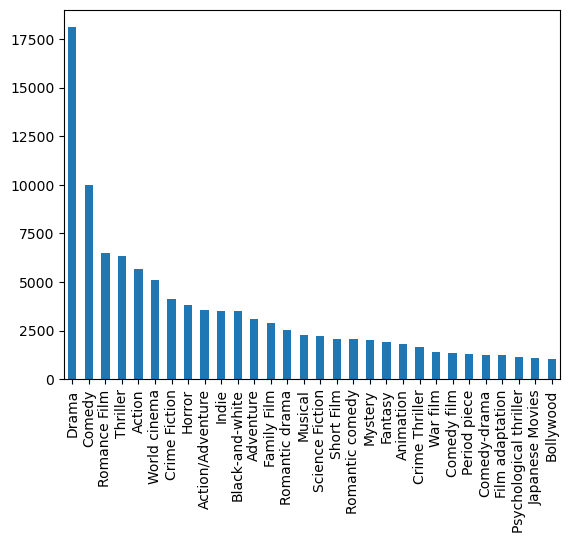

In [11]:
a = to_1D(moviedata_filtered['genres']).value_counts()

a = a[a>1000]

a.plot(kind='bar')

In [12]:
selected = a[:8].index
selected = selected.drop(["Drama",'World cinema'])
identification_genre = moviedata_filtered[['genres']].copy()
selected

Index(['Comedy', 'Romance Film', 'Thriller', 'Action', 'Crime Fiction',
       'Horror'],
      dtype='object')

In [13]:
for i in selected:
    identification_genre[str(i)] = identification_genre['genres'].apply(lambda x: 1 if i in x else 0)

In [14]:
triplets = list((combinations(selected,3)))
count_per_genre = np.zeros((len(triplets), 3))
count_unique_per_genre = np.zeros((len(triplets), 3)) 

In [15]:
for i, triplet in enumerate(triplets) :
    for j, genre in enumerate(triplet) :
        count_per_genre[i,j] = identification_genre.loc[:,genre].sum()
        others = list(triplet)
        others.remove(genre)
        count_unique_per_genre[i,j] = len(identification_genre[(identification_genre[genre] == 1) \
            & (identification_genre[others[0]] != 1)\
            & (identification_genre[others[1]] != 1)])

In [16]:
loss_genres = (count_per_genre - count_unique_per_genre) / count_per_genre
mean_loss = np.mean(loss_genres, axis=1)
mean_count = np.mean(count_unique_per_genre, axis=1)
min_loser = mean_loss.argsort()[:3]
highest_mean = mean_count.argsort()[-3:]
min_std = np.std(loss_genres, axis=1).argsort()[:3]

for i in min_loser:
    print(triplets[i])
for i in highest_mean:
    print(triplets[i])
for i in min_std:
    print(triplets[i])

('Romance Film', 'Crime Fiction', 'Horror')
('Romance Film', 'Action', 'Horror')
('Comedy', 'Crime Fiction', 'Horror')
('Comedy', 'Thriller', 'Horror')
('Comedy', 'Action', 'Horror')
('Comedy', 'Romance Film', 'Thriller')
('Romance Film', 'Action', 'Horror')
('Romance Film', 'Crime Fiction', 'Horror')
('Comedy', 'Action', 'Horror')


In [17]:
print(count_per_genre[min_loser[1],:], count_unique_per_genre[min_loser[1],:])
print(mean_loss[min_loser])

[6476. 5671. 3826.] [5938. 4854. 3399.]
[0.09455411 0.11291569 0.17252244]


In [18]:
selected_genres = triplets[min_loser[1]]

for genre in selected_genres:
    moviedata_filtered[genre] = moviedata_filtered['genres'].apply(lambda x: 1 if genre in x else 0)

moviedata_filtered['unique_genre'] = moviedata_filtered.loc[:,selected_genres].sum(axis = 1)

In [19]:
unique_genre = moviedata_filtered.drop(moviedata_filtered[moviedata_filtered['unique_genre'] != 1].index)

<AxesSubplot:>

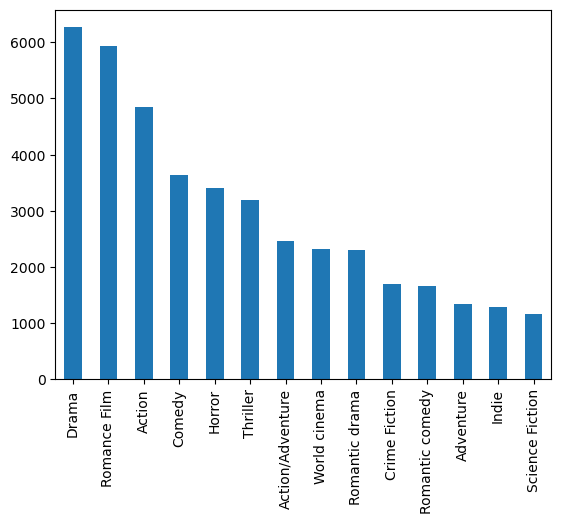

In [20]:
b = to_1D(unique_genre['genres']).value_counts()

b = b[b>1000]

b.plot(kind='bar')

In [21]:
unique_genre.head()

,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,,,
31186339,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Drama, Action/Adventure, Act...",0,1,0,1
20663735,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","[Drama, Bollywood, Musical, Action]",0,1,0,1
5272176,/m/0dbxtv,End Game,2006,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Drama, Thriller, Action/Adventure, Action]",0,1,0,1
1952976,/m/068jvg,Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Drama, Thriller, Horror]",0,0,1,1
2462689,/m/07ftxt,Meet John Doe,1941-05-03,NaN,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Media Satire, Comedy-drama, Drama, Comedy, Bl...",1,0,0,1


In [22]:
for genre in selected_genres:
    unique_genre['genres'] = unique_genre['genres'].apply(lambda x: genre if genre in x else x)

In [23]:
unique_genre.head()

,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,,,
31186339,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Action,0,1,0,1
20663735,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}",Action,0,1,0,1
5272176,/m/0dbxtv,End Game,2006,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",Action,0,1,0,1
1952976,/m/068jvg,Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Horror,0,0,1,1
2462689,/m/07ftxt,Meet John Doe,1941-05-03,NaN,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Romance Film,1,0,0,1


In [24]:
unique_genre['release'] = pd.to_datetime(unique_genre['release'], errors = 'coerce')
unique_genre['release'] = pd.DatetimeIndex(unique_genre['release']).year
unique_genre = unique_genre[unique_genre['release'].notna()]
unique_genre['release'] = unique_genre['release'].astype(int)


unique_genre['decade'] = (unique_genre['release']//10)*10
unique_genre['year'] = unique_genre['release']%10

In [25]:
unique_genre.head()

,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres,Romance Film,Action,Horror,unique_genre,decade,year
wiki_id,,,,,,,,,,,,,,
31186339,/m/0gkz15s,The Hunger Games,2012,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Action,0,1,0,1,2010,2
20663735,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}",Action,0,1,0,1,2000,0
5272176,/m/0dbxtv,End Game,2006,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",Action,0,1,0,1,2000,6
1952976,/m/068jvg,Dark Water,2005,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Horror,0,0,1,1,2000,5
2462689,/m/07ftxt,Meet John Doe,1941,NaN,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Romance Film,1,0,0,1,1940,1


In [26]:
horror = unique_genre.loc[unique_genre['genres'] == 'Horror'].copy()
horror_rev = horror['revenue'].mean()
action = unique_genre.loc[unique_genre['genres'] == 'Action'].copy()
action_rev = action['revenue'].mean()
romance = unique_genre.loc[unique_genre['genres'] == 'Romance Film'].copy()
romance_rev = romance['revenue'].mean()


In [27]:
print(horror_rev)
print(action_rev)
print(romance_rev)

38641764.661590524
94512116.92800575
43580335.9320331


In [28]:
horror_count = horror['revenue'].count()
action_count = action['revenue'].count()
romance_count = romance['revenue'].count()

In [29]:
print(horror_count)
print(action_count)
print(romance_count)

591
1389
1692


<AxesSubplot:xlabel='decade'>

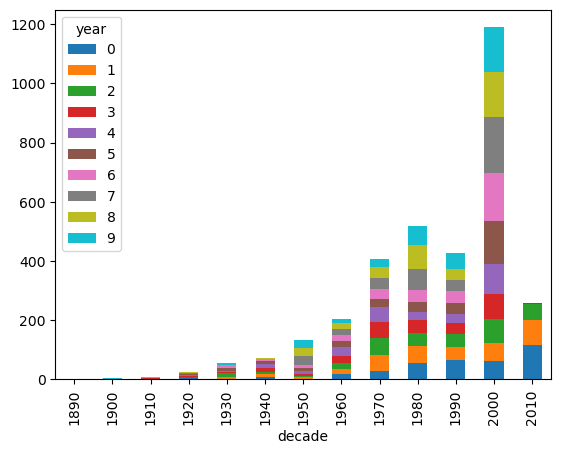

In [30]:
horror.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='decade'>

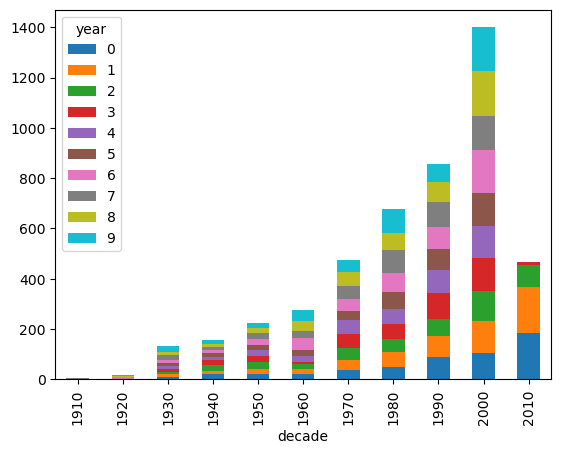

In [31]:
action.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='decade'>

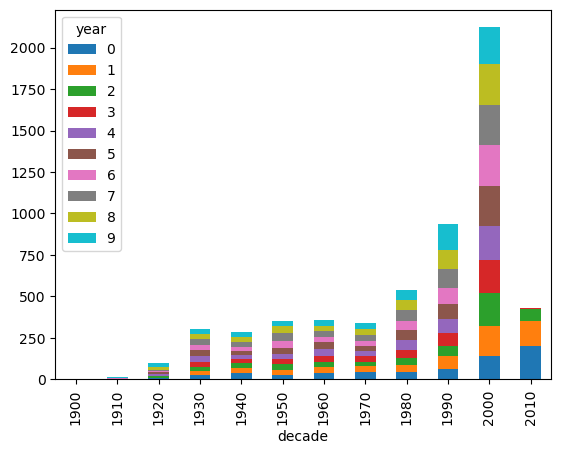

In [32]:
romance.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(stacked=True)

### Character data analysis

In [33]:
charadata.head()

,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map,1,2
wiki_id,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [34]:
charadata_filtered = charadata_filtered.drop(['freebase_id','freebase_chara_map','1','2'], axis = 1)

In [35]:
comedy_chardata = charadata_filtered.loc[horror.index.intersection(charadata_filtered.index)]
thriller_chardata = charadata_filtered.loc[action.index.intersection(charadata_filtered.index)]
romance_chardata = charadata_filtered.loc[romance.index.intersection(charadata_filtered.index)]

In [56]:
def count_chara(genre_data,character_genre):
    character_genre = character_genre.groupby('wiki_id')
    nb_characters = character_genre['actor_gender'].count()
    genre_data['nb_characters'] = nb_characters
    genre_data['nb_women'] = character_genre['actor_gender'].apply(lambda x: x[x == 'F'].count())
    genre_data['nb_men'] = character_genre['actor_gender'].apply(lambda x: x[x == 'M'].count())
    genre_data['ratio_gender'] = genre_data['nb_women'] / genre_data['nb_men']
    genre_data['average_age_men'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'M'].mean())
    genre_data['average_age_women'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'F'].mean())

In [57]:
count_chara(horror, comedy_chardata)
count_chara(action, thriller_chardata)
count_chara(romance, romance_chardata)

<BarContainer object of 11 artists>

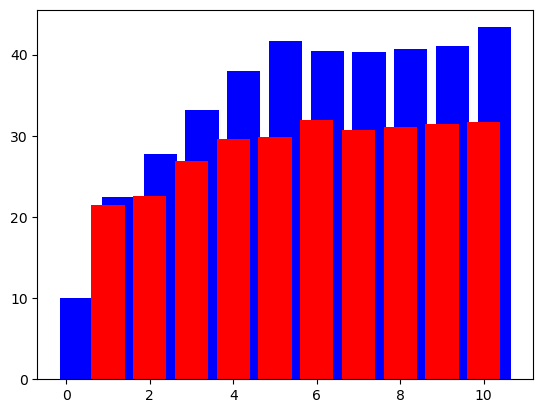

In [61]:
N = 11
ind = np.arange(N) 
width = 0.25

plt.bar(ind + width, action.groupby(['decade'])['average_age_men'].mean(), label='Men', color = 'blue')
plt.bar(ind, action.groupby(['decade'])['average_age_women'].mean(),  label='Women', color = 'red')

<BarContainer object of 13 artists>

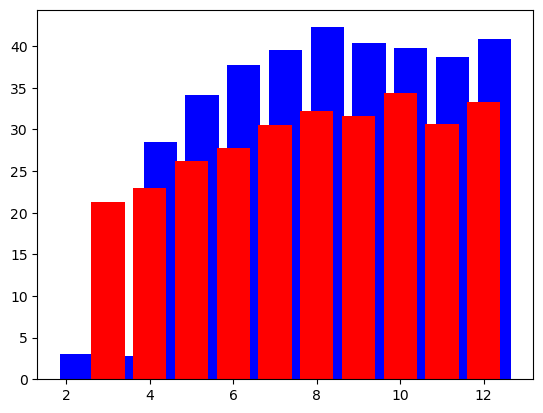

In [63]:
N = 13
ind = np.arange(N) 
width = 0.25

plt.bar(ind + width, horror.groupby(['decade'])['average_age_men'].mean(), label='Men', color = 'blue')
plt.bar(ind, horror.groupby(['decade'])['average_age_women'].mean(),  label='Women', color = 'red')

<BarContainer object of 12 artists>

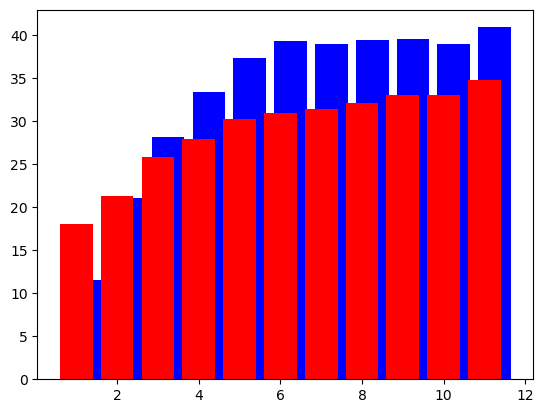

In [64]:
N = 12
ind = np.arange(N) 
width = 0.25

plt.bar(ind + width, romance.groupby(['decade'])['average_age_men'].mean(), label='Men', color = 'blue')
plt.bar(ind, romance.groupby(['decade'])['average_age_women'].mean(),  label='Women', color = 'red')